In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import XGBoost and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
# Load the dataset
df = pd.read_csv("../real_data/linkedin_jobs_preprocessed.csv")

# Select 1000 random samples
df = df.sample(3000, random_state=42)

In [3]:
# Combine text features into a single feature
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['description']


In [4]:
# Define the target variable and features
X = df['text']
y = df['annual_med_salary']

# Split the data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the training data, transform the testing data
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)


In [6]:
# Initialize models
ridge = Ridge()
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, verbose=-1)
lgbm = LGBMRegressor(random_state=42, force_col_wise=True, verbose=-1)

# Initialize models
ridge = Ridge()
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)

# Define hyperparameter grids for each model
ridge_param_grid = {'alpha': [0.1, 1, 10, 100]}
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6]
}
lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 62]
}

# Create a dictionary to store models and their parameters
models = {
    'Ridge': (ridge, ridge_param_grid),
    'RandomForest': (rf, rf_param_grid),
    'XGBoost': (xgb, xgb_param_grid),
    'LightGBM': (lgbm, lgbm_param_grid)
}

# Initialize a results dataframe
results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

In [7]:
# Create a dictionary to store models and their parameters
models = {
    'Ridge': (ridge, ridge_param_grid),
    'RandomForest': (rf, rf_param_grid),
    'XGBoost': (xgb, xgb_param_grid),
    'LightGBM': (lgbm, lgbm_param_grid)
}

# Initialize a results dataframe
results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])


In [8]:
# Initialize dictionaries to store results
best_estimators = {}
best_params = {}
model_performance = []

for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_estimators[model_name] = best_model
    best_params[model_name] = grid_search.best_params_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    # Predict on the test set
    y_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append results to the list
    model_performance.append({
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })


Training Ridge...
Best parameters for Ridge: {'alpha': 1}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 200}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.632586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136247
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 3381
[LightGBM] [Info] Start training from score 101886.669846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.639807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136719
[LightGBM] [Info] Number of data poi

In [9]:
# Convert performance list to dataframe
results = pd.DataFrame(model_performance)

# Display the results
print("\nModel Performance Comparison:")
print(results)


Model Performance Comparison:
          Model           MAE           MSE          RMSE        R2
0         Ridge  26100.246818  1.832275e+09  42805.083085  0.499817
1  RandomForest  29072.444425  2.229801e+09  47220.768232  0.391298
2       XGBoost  28704.636524  2.076516e+09  45568.801334  0.433143
3      LightGBM  25971.766891  1.892995e+09  43508.558107  0.483241


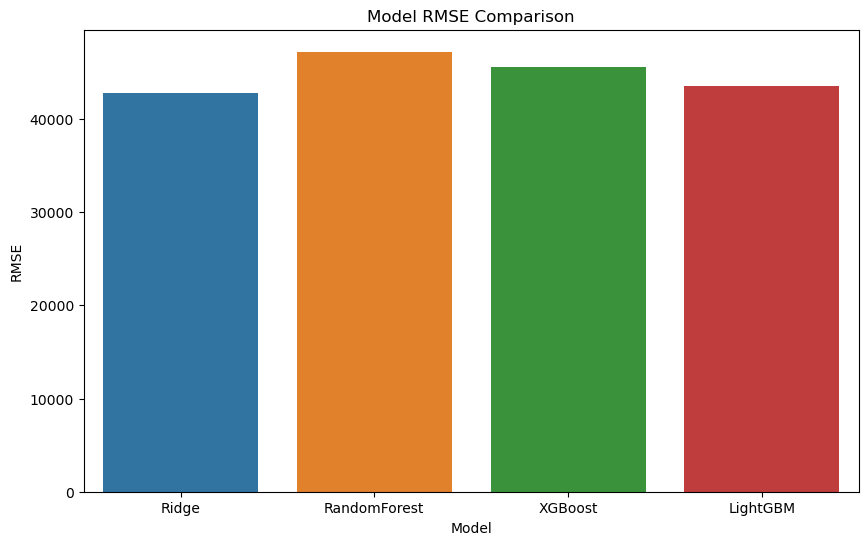

In [10]:
# Visualize the RMSE of each model
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

### Additional Analysis on the Best Model - Linear Regression (Ridge)

In [11]:
# Retrieve the best parameters and estimator for Ridge
best_ridge_params = best_params['Ridge']
best_ridge = best_estimators['Ridge']

# Predict on the test set using the best XGBoost model
y_pred_xgb = best_ridge.predict(X_test)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Ridge Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R-squared (R2): {r2_xgb:.2f}")

Ridge Model Performance:
Mean Absolute Error (MAE): 26100.25
Mean Squared Error (MSE): 1832275137.95
Root Mean Squared Error (RMSE): 42805.08
R-squared (R2): 0.50


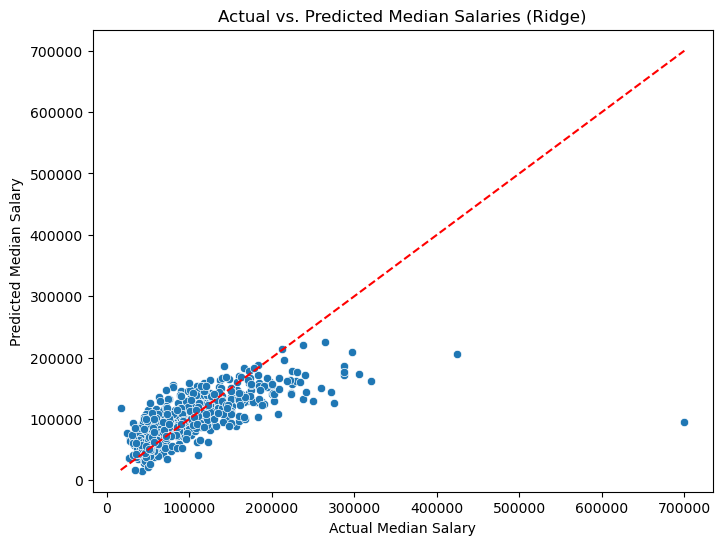

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.xlabel('Actual Median Salary')
plt.ylabel('Predicted Median Salary')
plt.title('Actual vs. Predicted Median Salaries (Ridge)')
# Plot a diagonal line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

/var/folders/pn/7qfxb93s0k9dqkgbt2l7sjgr0000gn/T/ipykernel_88369/2822401845.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Actual', shade=True)
/var/folders/pn/7qfxb93s0k9dqkgbt2l7sjgr0000gn/T/ipykernel_88369/2822401845.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_xgb, label='Predicted', shade=True)


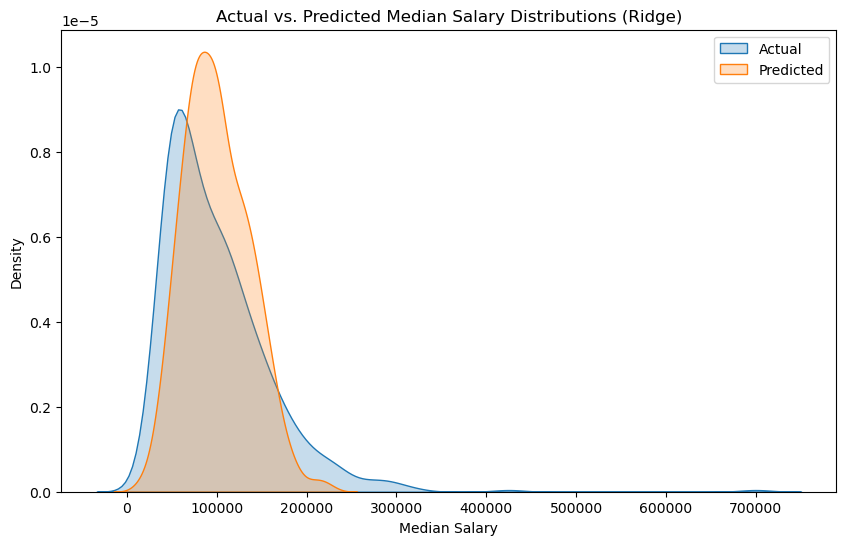

In [13]:
# Compare the actual and predicted med-salary distributions
plt.figure(figsize=(10,6))
sns.kdeplot(y_test, label='Actual', shade=True)
sns.kdeplot(y_pred_xgb, label='Predicted', shade=True)
plt.xlabel('Median Salary')
plt.ylabel('Density')
plt.title('Actual vs. Predicted Median Salary Distributions (Ridge)')
plt.legend()
plt.show()

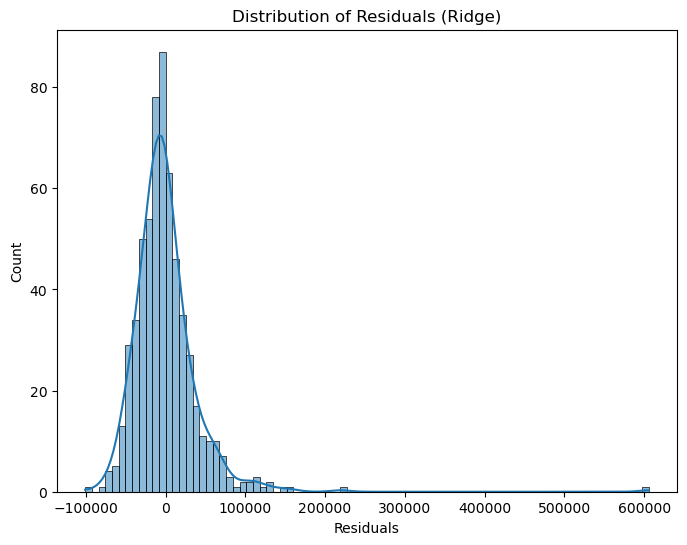

In [14]:
residuals_xgb = y_test - y_pred_xgb

plt.figure(figsize=(8,6))
sns.histplot(residuals_xgb, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals (Ridge)')
plt.show()

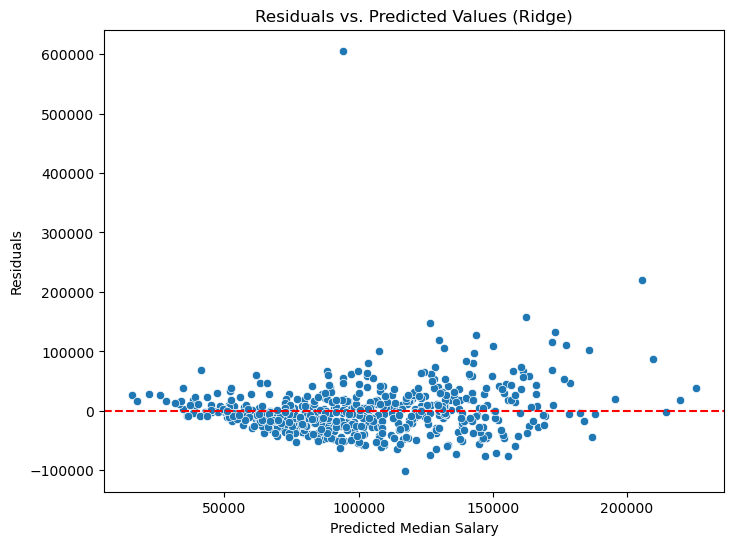

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb)
plt.xlabel('Predicted Median Salary')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (Ridge)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [22]:
# Get feature names from TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Get feature importances from the Ridge model
importances = best_ridge.coef_

# Create a DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the 10 most important features
print(feature_importance_df.head(20))

           Feature     Importance
4996          zero  115081.838135
927     cloudflare  105444.584187
2668         legal  105269.454773
2538            ip   95407.946093
4374     strategic   93703.332620
3508     president   90343.144215
3470      practice   90089.587204
4845          vice   85570.050549
3817    regulatory   85385.917924
2844       matters   84925.941333
1192       counsel   83465.851006
3645  psychiatrist   82274.974985
843        channel   77545.259813
710        builder   75300.637404
2161      guardian   74980.702852
4836     verticals   73106.410596
4310            sr   68595.493079
3646    psychiatry   68535.803762
2463  intellectual   66250.655673
1299          deal   64668.444581


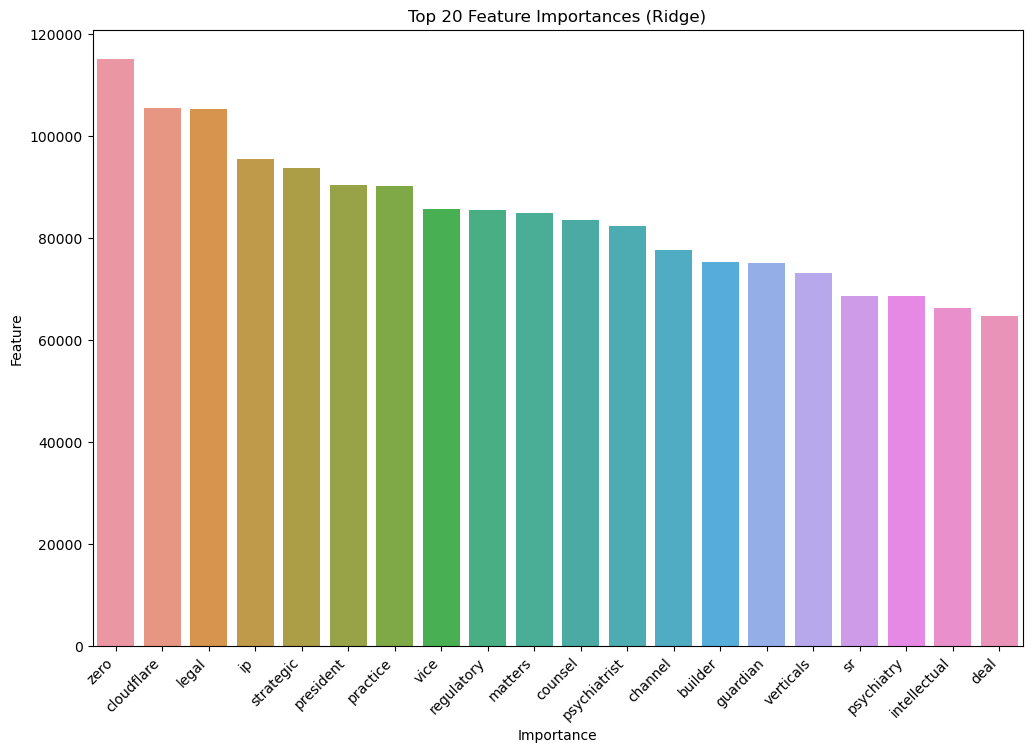

In [26]:
# Visualize the top 10 important features
plt.figure(figsize=(12,8))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances (Ridge)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45, ha='right')

plt.show()

In [21]:
# Add actual and predicted salaries to a DataFrame
results_df = X_test_text.reset_index(drop=True).to_frame()
results_df['Actual_Salary'] = y_test.reset_index(drop=True)
results_df['Predicted_Salary'] = y_pred_xgb
results_df['Residual'] = residuals_xgb.reset_index(drop=True)

# Sort by absolute residuals to find the highest errors
results_df['Abs_Residual'] = results_df['Residual'].abs()
high_error_cases = results_df.sort_values(by='Abs_Residual', ascending=False).head(5)

pd.set_option('display.max_colwidth', 2000)

print("Top 5 High Error Cases:")
print(high_error_cases[['text', 'Actual_Salary', 'Predicted_Salary', 'Residual']])


Top 5 High Error Cases:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

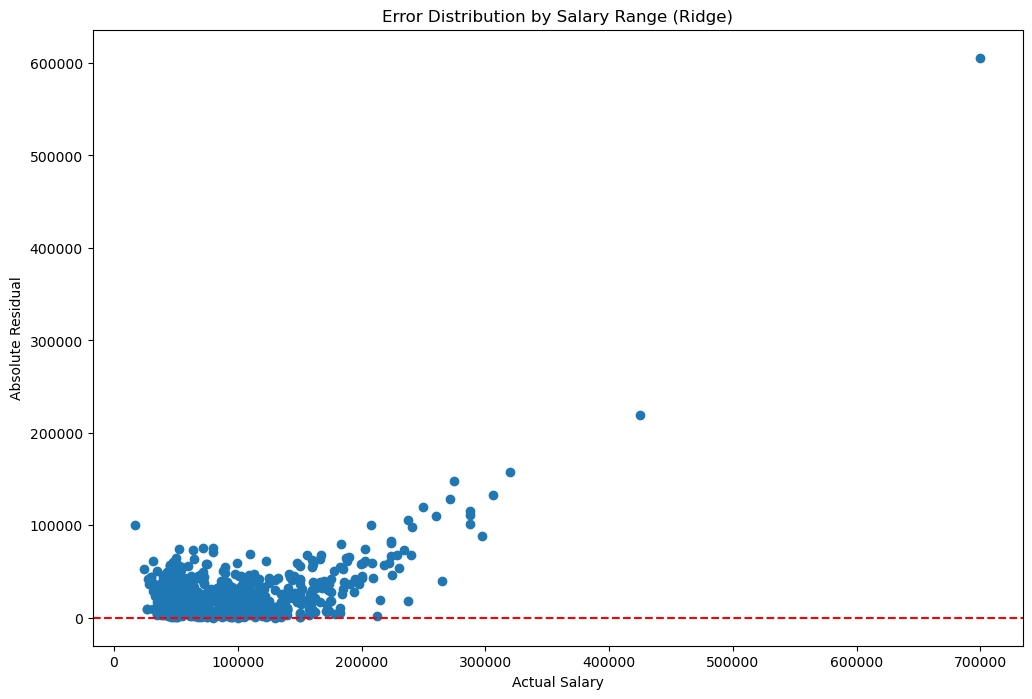

In [29]:
# Absolute Distribution by Salary Range (scatter plot)
plt.figure(figsize=(12,8))
plt.scatter(results_df['Actual_Salary'], results_df['Abs_Residual'])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Salary')
plt.ylabel('Absolute Residual')
plt.title('Error Distribution by Salary Range (Ridge)')
plt.show()